In [3]:
print("Starting script...")
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
print("Imports completed.")

Starting script...
Imports completed.


In [4]:
def preprocess_xray(image):
    try:
        print("preprocessing image...")
        
        #if not already in grayscale, convert
        if len(image.shape) == 3:
            print("Convert image to grayscale...")
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            print("Image is already in grayscale.")
            gray = image
        
        print("Applying CLAHE...")
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        print("CLAHE applied!.")
        
        print("Applying Gaussian blur...")
        blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
        print("Gaussian blur applied")
        
        print("applying thresholding...")
        _, thresh = cv2.threshold(blurred, 170, 255, cv2.THRESH_BINARY)
        print("Thresholding applied!")
        
        print("Inverting binary image...")
        inverted = cv2.bitwise_not(thresh)
        print("Image inversion complete")
        
        #apply morphological operations to clean up mask
        print("Applying morphological operations...")
        kernel = np.ones((5,5), np.uint8)
        cleaned = cv2.morphologyEx(inverted, cv2.MORPH_CLOSE, kernel, iterations=2)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel, iterations=1)
        print("Morphological operations complete")
        
        print("Image preprocessing completed!")
        return cleaned

    except Exception as e:
        print(f"Error occurred during image preprocessing: {str(e)}")
        raise

In [5]:
def find_pneumonia_region(mask):
    #find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return [x, y, x+w, y+h]
    else:
        return None

def process_images(dataset_path):
    results = []
    
    #iterate through images in directory
    for filename in os.listdir(dataset_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(dataset_path, filename)
            
            try:
                #load image
                image = cv2.imread(image_path, 0)  #read as grayscale
                if image is None:
                    print(f"Failed to load image: {filename}")
                    continue
                #preprocess image
                processed = preprocess_xray(image)
                
                #find pneumonia region
                pneumonia_box = find_pneumonia_region(processed)
                
                results.append({
                    'filename': filename,
                    'image': image,
                    'processed': processed,
                    'pneumonia_box': pneumonia_box
                })
                
                print(f"Successfully processed {filename}")
                
            except Exception as e:
                print(f"Error processing {filename} {str(e)}")
    
    return results

dataset_path = '/kaggle/input/preprocessingchestxray'

#process images
processed_images = process_images(dataset_path)

preprocessing image...
Image is already in grayscale.
Applying CLAHE...
CLAHE applied!.
Applying Gaussian blur...
Gaussian blur applied
applying thresholding...
Thresholding applied!
Inverting binary image...
Image inversion complete
Applying morphological operations...
Morphological operations complete
Image preprocessing completed!
Successfully processed chest xray.jpeg
preprocessing image...
Image is already in grayscale.
Applying CLAHE...
CLAHE applied!.
Applying Gaussian blur...
Gaussian blur applied
applying thresholding...
Thresholding applied!
Inverting binary image...
Image inversion complete
Applying morphological operations...
Morphological operations complete
Image preprocessing completed!
Successfully processed chest xray 2.jpeg


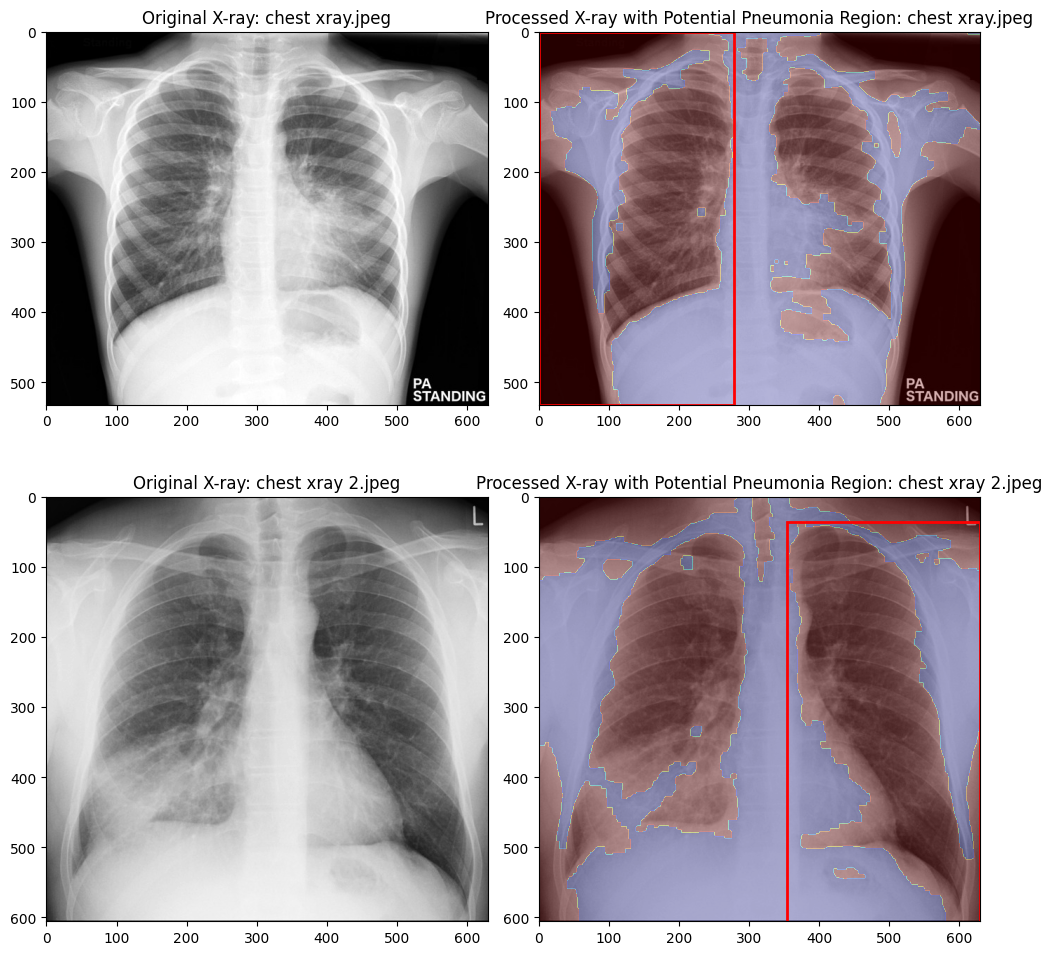

In [7]:
#visualization
fig, axes = plt.subplots(len(processed_images), 2, figsize=(10, 5*len(processed_images)))

for i, result in enumerate(processed_images):
    ax1, ax2 = axes[i] if len(processed_images) > 1 else axes
    
    ax1.imshow(result['image'], cmap='gray')
    ax1.set_title(f"Original X-ray: {result['filename']}")
    
    ax2.imshow(result['image'], cmap='gray')
    if result['pneumonia_box']:
        x, y, w, h = result['pneumonia_box']
        rect = plt.Rectangle((x, y), w-x, h-y, fill=False, edgecolor='red', linewidth=2)
        ax2.add_patch(rect)
    ax2.imshow(result['processed'], cmap='jet', alpha=0.3)
    ax2.set_title(f"Processed X-ray with Potential Pneumonia Region: {result['filename']}")

plt.tight_layout()
plt.show()